# **Tutorial 3: Stop detection in trajectories**

In this notebook we will explore some stop detection algorithms implemented in `nomad`. We will learn the differences between stop detection and traditional clustering algorithms, and the types of errors we need to watch out for.

### Download the data
Download the file [IC2S2-2025.zip](https://drive.google.com/file/d/1wk3nrNsmAiBoTtWznHjjjPkmWAZfxk0P/view?usp=drive_link) and extract it to this folder to obtain the sample trajectory data used in this tutorial.

## Load data

Let's use the same 3 week sample of data as in the previous notebook. Initially we will focus on data from a user in just one day, which we can filter at read time.

In [4]:
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import Polygon, box, Point

filepath_root = '/content/drive/MyDrive/Colab Notebooks/garden_city.geojson'
city = gpd.read_file(filepath_root).to_crs('EPSG:3857')
outer_box = box(*city.total_bounds).buffer(15, join_style='mitre')

filepath_root = '/content/drive/MyDrive/Colab Notebooks/gc_data_long'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','==', '2024-01-01'), traj_cols=tc)

Understanding the time component of the trajectory is important since the notion of a "stop" or a "visit" requires finding pings that indicate **stationary behavior**. Naturally this depends on the **pings being spatially close to one another, but also in the same period of time**. Let's try to visualize this temporal component on the map.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import shapely.plotting as shp_plt
from IPython.display import HTML
from nomad.stop_detection.viz import plot_stops_barcode, plot_pings, plot_stops, plot_time_barcode

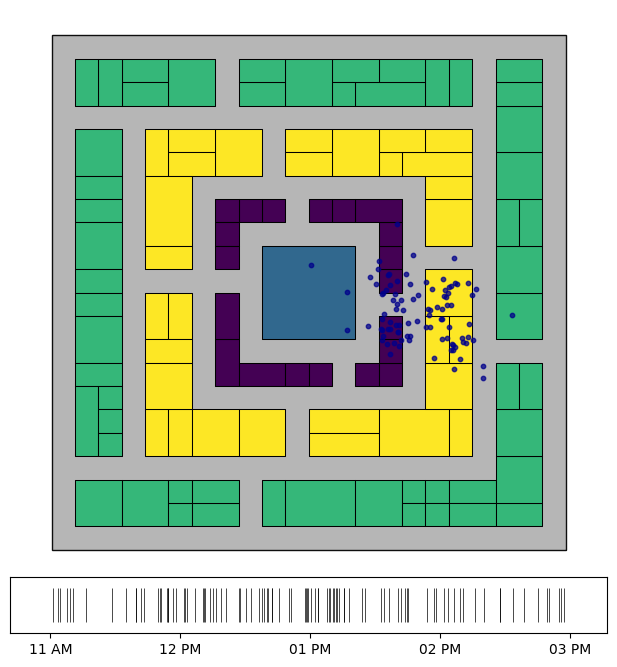

In [6]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5), gridspec_kw={'height_ratios':[10,1]})

# Map
shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, column='type', edgecolor='black', linewidth=0.75, cmap='viridis')
ax_map.scatter(traj['dev_x'], traj['dev_y'], s=10, color='darkblue', alpha=0.75)
ax_map.set_axis_off()

plot_time_barcode(traj['unix_ts'], ax_barcode)

plt.tight_layout(pad=0.1)
plt.show()

We can see that the pings are very dense for this user and correspond (apparently) to **4 visits to close by locations**. We would like to have a clustering algorithm that can recover:
1. **Where** those stops took place (with a centroid for example)
2. **When** the stop started, and how long it lasted

<small>*Expand the cell bellow to see a small animation for the image above!

## Stop detection algorithms

In [7]:
import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.filters as filters

### Sequential stop detection

The first stop detection algorithm implemented in ```nomad``` is a sequential algorithm insipired by the one in _Project Lachesis: Parsing and Modeling Location Histories_ (Hariharan & Toyama). This algorithm for extracting stays is dependent on two parameters: the roaming distance and the stay duration.

dur_min
* `delta_roam` is the Roaming distance ($\Delta_{\texttt{max}}$) represents the maximum distance an object can move away from a point location and still be considered to be staying at that location.
* `dur_min` is a minimum stop duration below which we consider the stop to be (potentially) spurious
* ```dt_max```: Maximum time gap permitted between consecutive pings in a stay in minutes (dt_max should be greater than dur_min).

The algorithm identifies stops as contiguous sequences of pings that have a diameter less than `delta_roam` for at least the duration of the stop duration.

In [8]:
LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, complete_output=True, keep_col_names=True, traj_cols=tc)

,cluster,x,y,unix_ts,ha,diameter,n_pings,end_timestamp,duration,max_gap,gc_identifier
0,0,-4.265482e+06,4.393153e+06,1704107777,11.006086,14.820705,3,1704108899,18,12,admiring_brattain
1,1,-4.265478e+06,4.393120e+06,1704112028,11.038392,16.458197,6,1704112657,10,3,admiring_brattain
2,2,-4.265482e+06,4.393117e+06,1704112843,12.200451,18.663269,4,1704113143,5,3,admiring_brattain
3,3,-4.265475e+06,4.393110e+06,1704113482,9.792796,8.638411,3,1704113875,6,6,admiring_brattain
4,4,-4.265449e+06,4.393130e+06,1704114942,11.163325,17.188732,6,1704116038,18,7,admiring_brattain
5,5,-4.265433e+06,4.393109e+06,1704117714,11.582069,19.549541,5,1704118232,8,2,admiring_brattain
6,6,-4.265435e+06,4.393109e+06,1704119274,11.059295,13.624470,3,1704119938,11,5,admiring_brattain


Optionally, we can get some useful statistics about each stop with the argument `complete_output`

In [9]:
stops = LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, complete_output=True, keep_col_names=True, traj_cols=tc)
stops

,cluster,x,y,unix_ts,ha,diameter,n_pings,end_timestamp,duration,max_gap,gc_identifier
0,0,-4.265482e+06,4.393153e+06,1704107777,11.006086,14.820705,3,1704108899,18,12,admiring_brattain
1,1,-4.265478e+06,4.393120e+06,1704112028,11.038392,16.458197,6,1704112657,10,3,admiring_brattain
2,2,-4.265482e+06,4.393117e+06,1704112843,12.200451,18.663269,4,1704113143,5,3,admiring_brattain
3,3,-4.265475e+06,4.393110e+06,1704113482,9.792796,8.638411,3,1704113875,6,6,admiring_brattain
4,4,-4.265449e+06,4.393130e+06,1704114942,11.163325,17.188732,6,1704116038,18,7,admiring_brattain
5,5,-4.265433e+06,4.393109e+06,1704117714,11.582069,19.549541,5,1704118232,8,2,admiring_brattain
6,6,-4.265435e+06,4.393109e+06,1704119274,11.059295,13.624470,3,1704119938,11,5,admiring_brattain


The diameter column can give us a notion of the extent of the stop. Larger stops reveal less precise information and could be evidence of **merging** two true stops. We can visualize them as circles with radius `stops['diameter']/2`

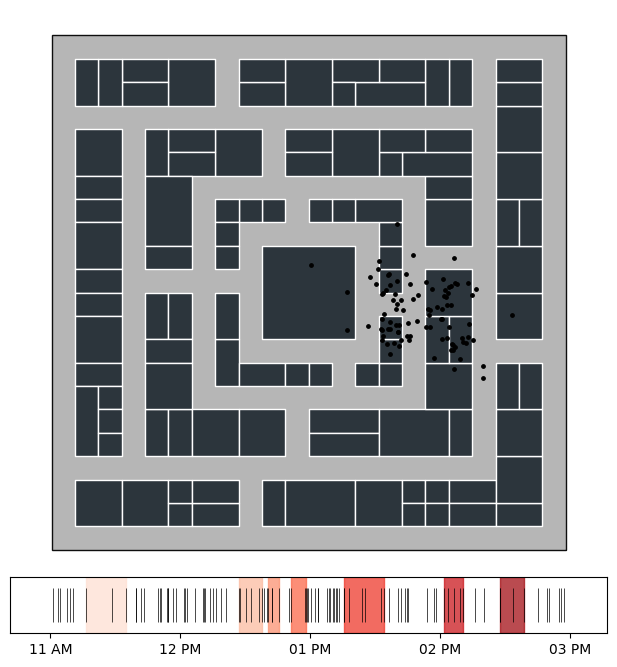

In [10]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#2c353c')

plot_stops(stops, ax=ax_map, cmap='Reds', x='dev_x', y='dev_y')
plot_pings(traj, ax=ax_map, s=6, point_color='black', cmap='twilight', traj_cols=tc)

ax_map.set_axis_off()

plot_time_barcode(traj[tc['timestamp']], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops, ax=ax_barcode, cmap='Reds', set_xlim=False, x='x', y='y', timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()

### Flexibility in input formats

The stop detection algorithms implemented in `nomad` support different combinations of input formats that are common in commercial datasets, detecting default names when possible
- timestamps in `datetime64[ns, tz]` or as unix seconds in integers
- geographic coordinates (`lon`, `lat`) which use the Haversine distance or projected coordinates (`x`, `y`) using meters and euclidean distance.
- Alternatively, if locations are only given through a spatial index like H3 or geohash, there is a **grid_based** clustering algorithm requiring no coordinates.

The algorithms work with the same call, provided there is at least a pair of coordinates (or a location/spatial index) as well as at least a temporal column.

In [8]:
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, x='dev_x', y='dev_y', data_crs='EPSG:3857')
traj['h3_cell']

,h3_cell
0,8a3593605ad7fff
1,8a3593605ad7fff
2,8a3593605ad7fff
3,8a3593605ad7fff
4,8a3593605ad7fff
...,...
91,8a3593605adffff
92,8a3593605adffff
93,8a3593605adffff
94,8a3593605adffff


In [14]:
import numpy as np
import pandas as pd
pd.set_option("mode.copy_on_write", True)
import h3

traj[['longitude','latitude']] = np.column_stack(
    filters.to_projection(traj, x='dev_x', y='dev_y', data_crs='EPSG:3857', crs_to='EPSG:4326')
)

traj['zoned_datetime'] = pd.to_datetime(traj['unix_ts'], unit='s', utc=True).dt.tz_convert('Etc/GMT-1')
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, latitude='latitude', longitude='longitude')

# Alternate datasets
traj_geog = traj[['latitude', 'longitude', 'zoned_datetime']]
traj_h3 = traj[['gc_identifier', 'unix_ts', 'h3_cell']]

# Very similar call
stops_lac =  LACHESIS.lachesis(traj_geog, delta_roam=25, dt_max = 45, dur_min=3, complete_output=True, latitude='latitude', longitude='longitude', datetime='zoned_datetime')
traj_geog['cluster'] = LACHESIS.lachesis_labels(traj_geog, delta_roam=25, dt_max = 45, dur_min=3, latitude='latitude', longitude='longitude', datetime='zoned_datetime')

stops_h3 = GRID_BASED.grid_based(traj_h3, time_thresh=180, dur_min=3, complete_output=True, timestamp='unix_ts', location_id='h3_cell')
traj_h3['cluster'] = GRID_BASED.grid_based_labels(traj_h3, time_thresh=180, dur_min=3, timestamp='unix_ts', location_id='h3_cell')

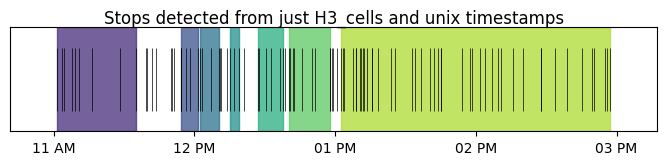

In [20]:
traj_h3[['dev_x','dev_y']] = traj[['dev_x','dev_y']]

fig, ax_barcode = plt.subplots(figsize=(6.5,1.5))

plot_time_barcode(traj_h3[tc['timestamp']], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_h3, ax=ax_barcode, cmap='viridis', set_xlim=False, timestamp='unix_ts')

fig.suptitle("Stops detected from just H3_cells and unix timestamps")
plt.tight_layout(pad=0.1)
plt.show()

### Density based stop detection (Temporal DBSCAN)

The second stop detection algorithm implemented in ```nomad``` is an adaptation of DBSCAN. Unlike in plain DBSCAN, we also incorporate the time dimension to determine if two pings are "neighbors". This implementation relies on 3 parameters

* `time_thresh` defines the maximum time difference (in minutes) between two consecutive pings for them to be considered neighbors within the same cluster.
* `dist_thresh` specifies the maximum spatial distance (in meters) between two pings for them to be considered neighbors.
* `min_pts` sets the minimum number of neighbors required for a ping to form a cluster.

Notice that this method also works with **geographic coordinates** (lon, lat), using Haversine distance.

In [16]:
users = ['confident_aryabhata']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','<=', '2024-01-03'), traj_cols=tc)
traj[['longitude','latitude']] = np.column_stack(
    filters.to_projection(traj, x='dev_x', y='dev_y', data_crs='EPSG:3857', crs_to='EPSG:4326')
)

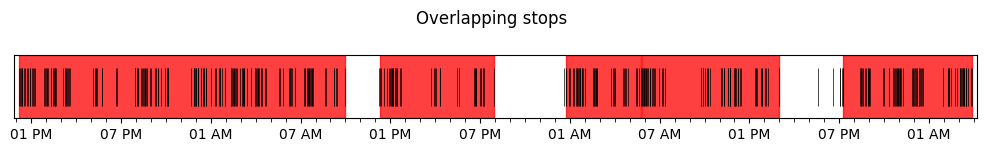

In [17]:
stops_dbscan = DBSCAN.ta_dbscan(traj,
                    time_thresh=720,
                    dist_thresh=15,
                    min_pts=3,
                    complete_output=True,
                    traj_cols=tc)

fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_dbscan, ax=ax_barcode, stop_color='red', set_xlim=False, timestamp='unix_ts')
fig.suptitle("Overlapping stops")
plt.tight_layout()
plt.show()

In [18]:
import nomad.stop_detection.postprocessing as post

post.invalid_stops(stops_dbscan, print_stops=True, **tc)
stops_dbscan.loc[stops_dbscan.unix_ts.isin([1704197861, 1704242618])]

,cluster,x,y,unix_ts,ha,diameter,n_pings,end_timestamp,duration,max_gap,gc_identifier
1,1,-4.265513e+06,4.393055e+06,1704197861,12.44818,43.731772,28,1704225293,457,294,confident_aryabhata
2,2,-4.265490e+06,4.393198e+06,1704242618,12.96571,48.313154,39,1704260592,299,54,confident_aryabhata


## Spatial-only algorithms can produce (temporally) invalid stop tables

While the parameter `time_thresh` helps mitigate this issue (this would be *pre-processing*). It seems like some post-processing is necessary to "break up" temporally overlapping stops.

One way is to use a **sequential location-based algorithm**, using DBSCAN's cluster labels **as "locations"**. For this we need the **disaggregated output** of the stop-detection algorithm

In [9]:
traj["cluster"] = DBSCAN.ta_dbscan_labels(traj,
                    time_thresh=720,
                    dist_thresh=15,
                    min_pts=3,
                    traj_cols=tc)

## Uncomment to see label counts
# traj.cluster.value_counts()

In [25]:
traj

,gc_identifier,dev_x,dev_y,unix_ts,ha,tz_offset,date,longitude,latitude,cluster
0,confident_aryabhata,-4.265516e+06,4.393040e+06,1704111151,9.940171,-14400,2024-01-01,-38.317783,36.668785,0
1,confident_aryabhata,-4.265521e+06,4.393051e+06,1704111275,12.917403,-14400,2024-01-01,-38.317828,36.668866,0
2,confident_aryabhata,-4.265521e+06,4.393061e+06,1704111660,9.529149,-14400,2024-01-01,-38.317826,36.668937,0
3,confident_aryabhata,-4.265510e+06,4.393068e+06,1704111704,10.096338,-14400,2024-01-01,-38.317727,36.668989,0
4,confident_aryabhata,-4.265505e+06,4.393050e+06,1704111741,13.339782,-14400,2024-01-01,-38.317688,36.668856,0
...,...,...,...,...,...,...,...,...,...,...
396,confident_aryabhata,-4.265566e+06,4.393104e+06,1704338918,15.048051,-14400,2024-01-03,-38.318228,36.669250,1
397,confident_aryabhata,-4.265562e+06,4.393088e+06,1704339010,9.201426,-14400,2024-01-03,-38.318194,36.669136,1
398,confident_aryabhata,-4.265554e+06,4.393088e+06,1704339350,8.434094,-14400,2024-01-03,-38.318120,36.669136,1
399,confident_aryabhata,-4.265569e+06,4.393087e+06,1704340058,8.223668,-14400,2024-01-03,-38.318262,36.669123,1


In [26]:
from nomad.stop_detection.utils import summarize_stop

new_cluster = GRID_BASED.grid_based_labels(
                        data=traj.loc[traj.cluster!=-1], # except noise pings
                        time_thresh=720,
                        min_cluster_size=3,
                        location_id="cluster", # grid_based requires a location column
                        traj_cols=tc)

traj.loc[traj.cluster!=-1, 'cluster'] = new_cluster

In [27]:
post_processed_stops = [
        summarize_stop(
            grouped_data=group,
            keep_col_names=True,
            complete_output=True,
            traj_cols=tc,
            passthrough_cols = ['cluster', 'gc_identifier']
        )
        for _, group in traj.loc[traj.cluster!=-1].groupby('cluster', as_index=False, sort=False)
    ]
post_processed_stops = pd.DataFrame(post_processed_stops)

print("Invalid stops?")
post.invalid_stops(post_processed_stops, print_stops=True, **tc)

Invalid stops?


False

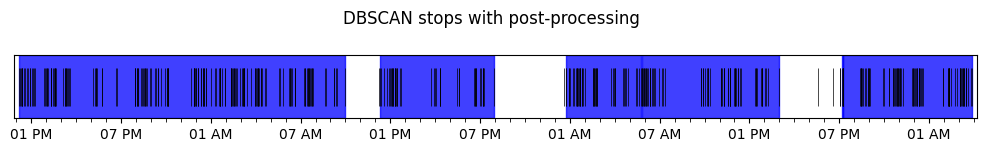

In [28]:
fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(post_processed_stops, ax=ax_barcode, stop_color='blue', set_xlim=False, timestamp='unix_ts')
fig.suptitle("DBSCAN stops with post-processing")
plt.tight_layout()
plt.show()

This post-processing is also wrapped in the method `nomad.stop_detection.postprocessing.remove_overlaps`

In [ ]:
# post_processed_stops = post.remove_overlaps(traj, time_thresh=720, method='cluster', traj_cols=tc)

## Which algorithm to choose? which parameters

This is not a trivial problem and researchers often rely on "trial and error" or, worse, default parameters. A semi-informed choice could depend on:


| Factor | Implication |
| --- | --- |
| Signal sparsity | Denser data → increase DBSCAN `min_pts` to prevent over‑clustering |
| Noise level | Higher noise (low accuracy) → use larger distance thresholds |
| Building proximity | Dense areas → use smaller distance thresholds |
| Scalability | More robust methods → longer execution time |

We could do **a parameter search** by keeping track of some statistics of the output of several stop detection algorithms

In [26]:
traj = loader.sample_from_file(filepath_root, frac_users=0.1, format='parquet', traj_cols=tc, seed=10) # try frac_users = 0.1

# Rename 'gc_identifier' to 'user_id'
traj = traj.rename(columns={'gc_identifier': 'user_id'})

# H3 cells for grid_based stop detection method
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, x='dev_x', y='dev_y', data_crs='EPSG:3857')
pings_per_user = traj['user_id'].value_counts() # Updated to use 'user_id'
tc['user_id'] = 'user_id'

In [33]:
import time
from tqdm import tqdm
import nomad.stop_detection.hdbscan as HDBSCAN
import pandas as pd

# Approximately 5 minutes for 40 users
results = []
for user, n_pings in tqdm(pings_per_user.items(), total=len(pings_per_user)):
    user_data = traj.query("user_id == @user") # Updated to use 'user_id'

    # For location based
    start_time = time.time()
    stops_gb = GRID_BASED.grid_based_per_user(user_data, time_thresh=240, complete_output=True, timestamp='unix_ts', location_id='h3_cell')
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'grid_based', 'execution_time':execution_time, 'n_pings':n_pings})]

    # For Lachesis
    start_time = time.time()
    stops_lac = LACHESIS.lachesis(user_data, delta_roam=30, dt_max=240, complete_output=True, traj_cols=tc)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'lachesis', 'execution_time':execution_time, 'n_pings':n_pings})]

    # For TADbscan
    start_time = time.time()
    user_data_tadb = user_data.assign(cluster=DBSCAN.ta_dbscan_labels(user_data, time_thresh=240, dist_thresh=15, min_pts=3, traj_cols=tc))
    # - post-processing
    stops_tadb = post.remove_overlaps(user_data_tadb, time_thresh=240, method='cluster', traj_cols=tc, min_cluster_size=2)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'tadbscan', 'execution_time':execution_time, 'n_pings':n_pings})]

    # For HDBSCAN
    start_time = time.time()
    user_data_hdb = HDBSCAN.st_hdbscan_per_user(user_data, time_thresh=720, dist_thresh=15, min_pts=3, complete_output=True, traj_cols=tc)
    # - post-processing
    stops_hdb = post.remove_overlaps(user_data_hdb, time_thresh=240, method='cluster', traj_cols=tc)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'hdbscan', 'execution_time':execution_time, 'n_pings':n_pings})]

results = pd.DataFrame(results)

100%|██████████| 35/35 [06:38<00:00, 11.38s/it]
